In [2]:
import numpy as np
import math
import heapq
import ray
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
from ray import tune, rllib, air
from ray.rllib.algorithms.ppo import PPOConfig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env

In [28]:
def check_move_validity(agent_position:np.ndarray, action:int, edge_capacity, macros, length, width):
    """
    Check whether a move is valid by checking:
    (1) the edge the move is about to use has capacity greater than 0
    (2) the position after the move is not within macro regions
    (3) the position after the move in within in the routing canvas
    Returns True if the move is valid, False if invalid
    """
    #bound_flag = True
    #capacity_flag = True
    #macro_flag = True

    # capacity of the 4 neighbouring edges of the current agent position
    node_capacity = edge_capacity[agent_position[0]][agent_position[1]]
    print("node capacity ",node_capacity)

    if action == 0: # up
        new_position = (agent_position[0], agent_position[1]+1)
    elif action == 1: # right
        new_position = (agent_position[0]+1, agent_position[1])
    elif action == 2: # down
        new_position = (agent_position[0], agent_position[1]-1)
    elif action == 3: # left
        new_position = (agent_position[0]-1, agent_position[1])
    print("new position ",new_position)

    macro_flag = new_position not in macros
    print("not in macros? ", macro_flag)
    bound_flag = new_position[0] in range(length) and new_position[1] in range(width)
    print("within bound? ", bound_flag)
    capacity_flag = node_capacity[action] > 0
    print("capacity of the intended edge ", node_capacity[action])
    print("enoough capacity? ", capacity_flag)
    valid = macro_flag and bound_flag and capacity_flag

    return valid

In [39]:
# TODO: nodes in the corners?
edge_capacity = np.zeros([5,5,4])
edge_capacity[4][4] = np.array([0,0,10,9])
agent_position = np.array([4,4])
action = 3
length = 5
width = 5
macros = [(0,2), (1,1)]

check_move_validity(agent_position, action, edge_capacity, macros, length, width)




node capacity  [ 0.  0. 10.  9.]
new position  (3, 4)
not in macros?  True
within bound?  True
capacity of the intended edge  9.0
enoough capacity?  True


True

In [4]:
# define the custom routing grid environemnt

# action space encoding
    # 0 - > move up
    # 1 - > move down
    # 2 - > move right
    # 3 - > move left
# state (observation) space encoding
    # state[0:1] = current agent position
    # state[2:3] = current goal position
    # state[4:7] = capacities of the four neighbouring edges of the current agent position. Namely, up, right, down, and left


class RtGridEnv(Env):
    def __init__(self, length, width, nets, macros, edge_capacity):
        """
        Args:
            length (int): length of the canvas
            width (int): width of the canvas
            nets (list): a list of nets to be routed
            macros (list): a list of macros that has been placed on the canvas by placement
        """

        self.length = length
        self.width = width

        self.nets = nets
        self.macros = macros
        self.edge_capacity = edge_capacity
        self.max_capcacity = np.max(self.edge_capacity)

        self.pin_counter = 0 # counts the number of pins within a net that have been routed
        self.net_counter = 0 # counts the number of nets that have been routed
        self.change_net_flag = False # tells the step function to change to a new multi-pin net
        self.change_pin_flag = False # tells the step function to change to a new 2-pin net
        self.done_flag = False 

        self.path_x = self.generate_path_list(self.nets)
        self.path_y = self.generate_path_list(self.nets)

        #self.path_x = [[] for _ in range(len(self.nets))] # holds the x coordinates of the path for each net as a sub-list
        #self.path_y = [[] for _ in range(len(self.nets))] 

        # decompose the multi-pin nets into 2-pin nets
        self.decomposed_nets = []
        for net in self.nets:
            self.decomposed_nets.append(self.prim_mst(net))

        print(self.decomposed_nets)
        #print(self.macros)

        # initialize the agent to route the first 2-pin net decompsoed from the first multi-pin net
        self.update_positions()

        # initialize the path lists
        self.update_path()

        # define the action and the observation space
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.length, self.width, self.length, self.width, self.max_capcacity, self.max_capcacity, self.max_capcacity])

        #print("initial agent position: ", self.agent_position)
        #print("initial goal position: ", self.goal_position)
        #print("initial path x: ", self.path_x)
        #print("initial path y: ", self.path_y)

        # Define the position and size of the rectangle obstacle
        '''self.rect_x = 1
        self.rect_y = 0
        self.rect_length = 2
        self.rect_width = 2

        self.obst_x_range = np.array(range(self.rect_x, self.rect_x+self.rect_length+1))
        self.obst_y_range = np.array(range(self.rect_y, self.rect_y+self.rect_width+1))'''
    
    def generate_edge_capacity(self):
        pass
    
    def generate_path_list(self, nets:list):
        """
        Generate the list data strcture to hold the path travelled by the agent
        """
        path = []
        for i in range (len(nets)):
            path.append([])
            for j in range (len(nets[i])-1):
                path[i].append([])
        return path

    def prim_mst(self, pins):
        """
        Compute the Minimum Spanning Tree (MST) using Prim's algorithm.

        Args:
            pins (list): List of (x, y) coordinates representing the pin locations.

        Returns:
            dict: a dictionary containing the vertices of all the edges in the MST

        Note:
            - The pins list should contain at least two points.
        """

        def euclidean_distance(p1, p2):
            """
            Compute the Euclidean distance between two points.

            Args:
                p1 (tuple): First point (x, y) coordinates.
                p2 (tuple): Second point (x, y) coordinates.

            Returns:
                float: Euclidean distance between the two points.
            """
            x1, y1 = p1
            x2, y2 = p2
            return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        distances = {}
        for i in range(len(pins)):
            for j in range(i+1, len(pins)):
                p1 = pins[i]
                p2 = pins[j]
                distances[(i, j)] = euclidean_distance(p1, p2)
                distances[(j, i)] = distances[(i, j)]  # Add symmetric distance
        
        # Initialize
        num_pins = len(pins)
        visited = [False] * num_pins
        mst_u = []
        mst_v = []
        start_vertex = 0
        visited[start_vertex] = True
        
        # Create a priority queue
        pq = []
        
        # Mark the initial vertex as visited
        for i in range(num_pins):
            if i != start_vertex:
                heapq.heappush(pq, (distances[(start_vertex, i)], start_vertex, i))
        
        # Print initial priority queue
        #print("Initial priority queue:")
        #for item in pq:
            #print(item)
        #print()
        
        # Update the priority queue and perform Prim's algorithm
        while pq:
            if (len(mst_u) == len(pins) -1): # for n pins, the MST should at most have n-1 edges
                break

            weight, u, v = heapq.heappop(pq)
            #print("Selected edge:")
            #print(weight, u, v)
            #print()
            
            if visited[v]:
                #print(f"Skipping edge: {weight} - {u} - {v}")
                continue
            
            # Prim's algorithm iteration
            visited[v] = True
            #print("u:",u)
            #print("v:",v)
            mst_u.append(pins[u])
            mst_v.append(pins[v])
            
            for i in range(num_pins):
                if not visited[i]:
                    heapq.heappush(pq, (distances[(v, i)], v, i))
        
        mst = {'u':mst_u,'v':mst_v}

        return mst
    
    def update_counters(self):
        # one 2-pin net within one multi-pin net is done
        #done = False
        self.pin_counter += 1
        self.change_pin_flag = True

        if self.pin_counter == len(self.nets[self.net_counter]) - 1:
            # this multi-pin net is done
            self.pin_counter = 0
            self.net_counter += 1
            self.change_net_flag = True
            if self.net_counter == len(self.nets):
                # all nets are done, raise the done flag
                self.done_flag = True

        #return done
    
    def update_positions(self):
        self.agent_position = np.array(self.decomposed_nets[self.net_counter]['u'][self.pin_counter])
        self.goal_position = np.array(self.decomposed_nets[self.net_counter]['v'][self.pin_counter])

    def update_path(self):
        self.path_x[self.net_counter][self.pin_counter].append(self.agent_position[0])
        self.path_y[self.net_counter][self.pin_counter].append(self.agent_position[1])

    def step(self, action):
        def check_move_validity(agent_position:np.ndarray, action:int):
            """
            Check whether a move is valid by checking:
            (1) the edge the move is about to use has capacity greater than 0
            (2) the position after the move is not within macro regions
            (3) the position after the move in within in the routing canvas
            Returns True if the move is valid, False if invalid
            """

            # capacity of the 4 neighbouring edges of the current agent position
            node_capacity = self.edge_capacity[agent_position[0]][agent_position[1]]

            if action == 0: # up
                new_position = (agent_position[0], agent_position[1]+1)
            elif action == 1: # right
                new_position = (agent_position[0]+1, agent_position[1])
            elif action == 2: # down
                new_position = (agent_position[0], agent_position[1]-1)
            elif action == 3: # left
                new_position = (agent_position[0]-1, agent_position[1])

            macro_flag = new_position not in self.macros
            bound_flag = new_position[0] in range(self.length) and new_position[1] in range(self.width)
            capacity_flag = node_capacity[action] > 0

            valid = macro_flag and bound_flag and capacity_flag

            return valid

        #print("upon calling the step function, agent position is {}, goal position is {}, pin counter is {}, net counter is {}".format(self.agent_position, self.goal_position, self.pin_counter, self.net_counter))

        if self.change_pin_flag and not self.change_net_flag:
            #print("we need to change 2-pin net")
            self.update_positions()
            self.update_path()
            #print("after changing to a new 2-pin net, agent position is {}, goal position is {}, pin counter is {}, net counter is {}".format(self.agent_position, self.goal_position, self.pin_counter, self.net_counter))
            reward = 0
            self.change_pin_flag = False
            return self.agent_position, reward, self.done_flag, {}
        
        elif self.change_net_flag:
            #print("we need to change net")
            self.update_positions()
            self.update_path()
            #print("after changing to a new net, agent position is {}, goal position is {}, pin counter is {}, net counter is {}".format(self.agent_position, self.goal_position, self.pin_counter, self.net_counter))
            reward = 0
            self.change_net_flag = False
            return self.agent_position, reward, self.done_flag, {}

        '''print("1 position ", self.agent_position)
        print("1 pin ",self.pin_counter)
        print("1 net ",self.net_counter)
        print("1 path x ", self.path_x)
        print("1 path y ",self.path_y)'''

        if action == 0:  # Up
             if check_move_validity(self.agent_position, action):
                self.agent_position[1] = self.agent_position[1] + 1
        elif action == 1:  # Right
            if check_move_validity(self.agent_position, action):
                self.agent_position[0] = self.agent_position[0] + 1
        elif action == 2:  # Down
            if check_move_validity(self.agent_position, action):
                self.agent_position[1] = self.agent_position[1] - 1
        elif action == 3:  # Left
            if check_move_validity(self.agent_position, action):
                self.agent_position[0] = self.agent_position[0] - 1

        self.update_path()

        # TODO: UPDATE CAPACITY

        '''print("2 position ", self.agent_position)
        print("2 pin ",self.pin_counter)
        print("2 net ",self.net_counter)
        print("2 path x ", self.path_x)
        print("2 path y ",self.path_y)'''
        
        # compute the reward
        if np.array_equal(self.agent_position, self.goal_position):
            #print("We reached a goal! update counters")
            reward = 10
            self.update_counters()
            #print("after updating couters, pin counter is {}, net counter is {}".format(self.pin_counter, self.net_counter))
        else:
            reward = -1
        
        #if not done:
            #self.update_path()

        #done = np.array_equal(self.agent_position, self.goal_position)
        #reward = 10 if done else -1

        # Update the agent's path
        #self.path_x.append(self.agent_position[0])  
        #self.path_y.append(self.agent_position[1])  

        # TODO: UPDATE STATE VECTOR
        return self.agent_position, reward, self.done_flag, {}
    
    def render(self):
        """
        Plot the agent's path
        """
        # Create a new figure and axis
        #fig, ax = plt.subplots()

        # Create a Rectangle patch
        #rectangle = patches.Rectangle((self.rect_x, self.rect_y), self.rect_length, self.rect_width, linewidth=1, edgecolor='g', facecolor='g')

        # Add the rectangle to the axis
        #ax.add_patch(rectangle)

        # Plot the agent path
        #print(self.path_x)
        #print(self.path_y)

        colors = cm.rainbow(np.linspace(0, 1, len(self.path_x)))


        for i in range(len(self.path_x)):
            color = colors[i]
            for j in range(len(self.path_x[i])):
                plt.plot(self.path_x[i][j], self.path_y[i][j], color = color)

        #for net in range(len(self.path_x)):
            #plt.plot(self.path_x[net], self.path_y[net])

        # plot the pins
        for net in self.nets:
            x_coords, y_coords = zip(*net)
            plt.scatter(x_coords, y_coords)

        # plot the macro pins
        for point in self.macros:
            x, y = point
            plt.scatter(x,y, color='green')

        # Set the labels and title
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Nets')

        # Set the x and y axis limits
        #plt.xlim(0, self.length-1)
        #plt.ylim(0, self.width-1)

        # Set the x and y axis ticks
        plt.xticks(range(0, self.length))
        plt.yticks(range(0, self.width))

        # Set the grid
        plt.grid(color='blue', linestyle='--', linewidth=0.5)

        # Show the plot
        plt.show()

    def reset(self):
        self.pin_counter = 0
        self.net_counter = 0
        self.change_net_flag = False
        self.change_pin_flag = False
        self.done_flag = False
        self.path_x = self.generate_path_list(self.nets)
        self.path_y = self.generate_path_list(self.nets)
        #self.path_x = [[] for _ in range(len(self.nets))]
        #self.path_y = [[] for _ in range(len(self.nets))]
        self.update_positions()
        self.update_path()

        self.state = np.concatenate([self.agent_position, self.goal_position, self.edge_capacity[agent_position[0]][agent_position[1]]])
        return self.state

IndentationError: expected an indented block after function definition on line 72 (1236357006.py, line 74)

27


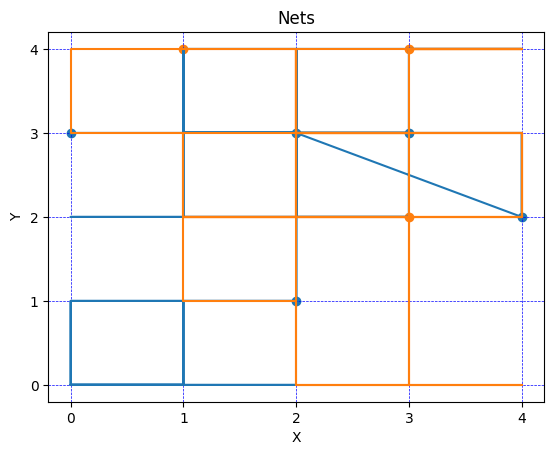

[[2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 4, 3, 2, 1, 1, 1, 0, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 1, 1, 2, 3, 2, 2, 1, 2, 3, 4, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0], [1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 3, 3, 3, 2, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 2, 3, 3, 4, 3, 2, 2, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 4, 3, 3, 2, 3, 2, 2, 3]]
[[1, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 3, 3, 4, 4, 4, 4, 3, 3], [4, 4, 3, 3, 2, 2, 2, 2, 3, 4, 4, 4, 3, 3, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2]]
49


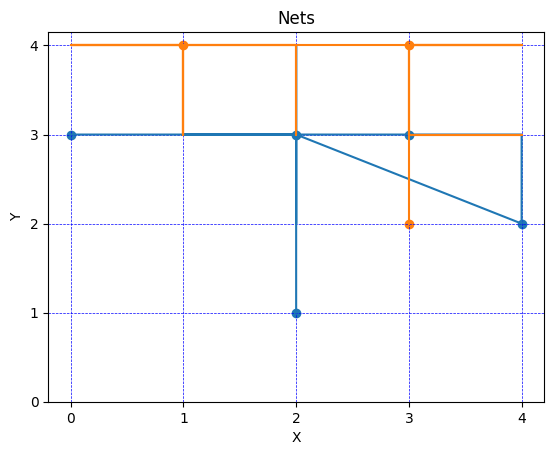

[[2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 4, 4, 2, 2, 2, 1, 0], [1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3]]
[[1, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 2]]
39


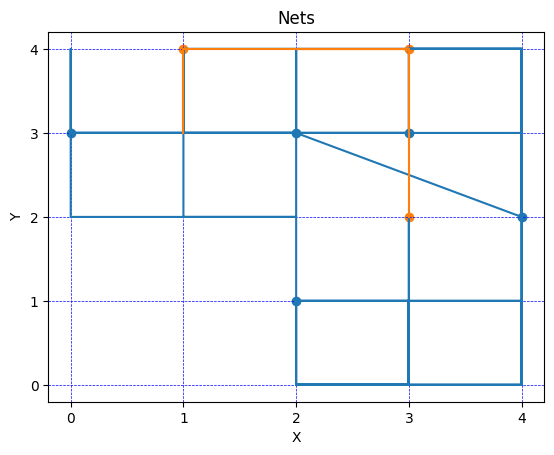

[[2, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 3, 2, 2, 2, 3, 2, 3, 4, 4, 4, 4, 4, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 4, 4, 3, 4, 4, 4, 4, 2, 1, 1, 1, 0], [1, 1, 1, 1, 1, 2, 3, 3, 2, 3, 3, 3]]
[[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 3, 3, 3, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 2, 3, 3, 4, 3, 3], [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 2]]


In [56]:
nets = [[(2,1), (2,3), (3,3), (4,2), (0,3)],[(1,4), (3,4), (3,2)]]
macros = [(0,1), (0,2), (0,3), (1,1), (1,2), (1,3)]
macros = []
env = RtGridEnv(5,5,nets, macros)
num_episodes = 3

for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward
            
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")

        if done:
            break
    print(total_reward)
    env.render()

In [47]:
# check the environment
register_env("routing_grid_env", lambda config: RtGridEnv(5,5,nets, macros))
env = RtGridEnv(5,5,nets, macros)

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

checking environment ...
All checks passed. No errors found.


In [49]:
# configure a new agent based on the tuning results obtained above
config2 = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .rollouts(num_rollout_workers=1)
    .evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
    .training(lr=0.00005)
)
algo = config2.build()

(RolloutWorker pid=7670) 2023-07-09 11:15:12,731	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=7721) 2023-07-09 11:15:16,517	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-07-09 11:15:17,095	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [50]:
# train the new agent using RLlib.train() in a loop
num_iterations = 20
rewards = []
checkpoint_dir = "saved_runs/SteinerCongestionAware/"

for i in range(num_iterations):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])

    # save a checkpoint and evaluate the policy at the end of the training
    if (i==num_iterations-1):
        checkpoint_file = algo.save(checkpoint_dir)
        eval_result = algo.evaluate()
print(rewards)

[31.04, 32.63492063492063, 35.05, 38.03, 38.93, 40.113821138211385, 41.386861313868614, 42.47159090909091, 43.353846153846156, 43.66304347826087, 44.0762331838565, 44.58064516129032, 44.900432900432904, 45.209219858156025, 45.148014440433215, 45.43606557377049, 45.4873417721519, 45.49034749034749, 45.58273381294964, 45.74782608695652]


In [51]:
# reload the policy from checkponit and run inference
checkpoint = "./saved_runs/SteinerCongestionAware/checkpoint_000020"
#new_config = PPOConfig()
algo = config2.build()
algo.restore(checkpoint)

(RolloutWorker pid=7844) 2023-07-09 11:16:59,530	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=7899) 2023-07-09 11:17:03,309	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-07-09 11:17:03,883	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-07-09 11:17:04,014	INFO trainable.py:790 -- Restored on 10.0.0.81 from checkpoint: saved_runs/SteinerCongestionAware/checkpoint_000020
2023-07-09 11:17:04,014	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 

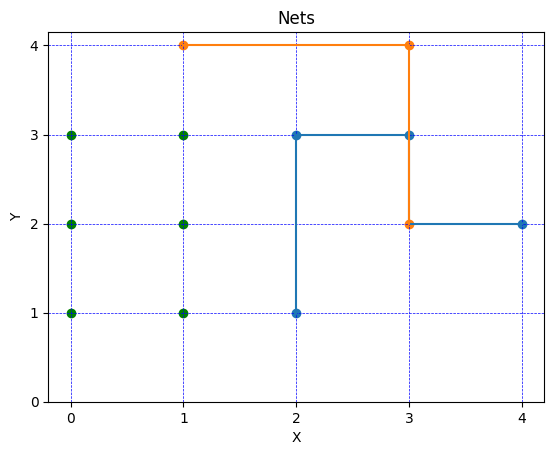

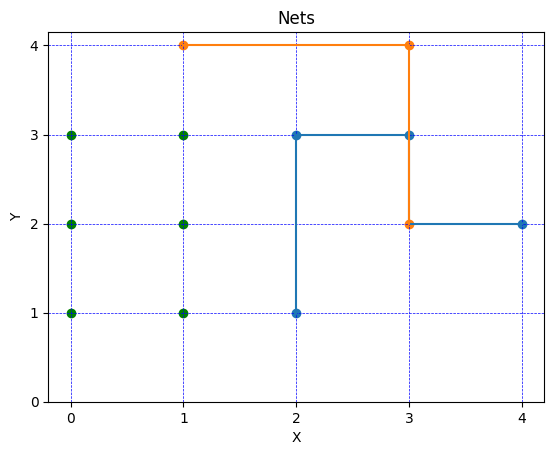

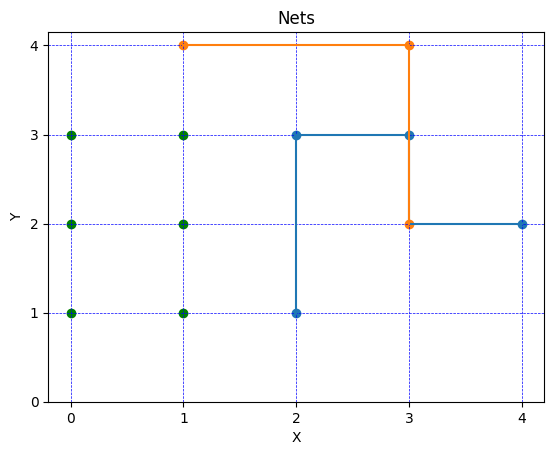

In [52]:
# play and render the game
num_episodes = 3
total_reward = 0

for ep in range(num_episodes):
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=False)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
    env.render()
#env.close()